# RMSProp
RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

## RMSProp 算法
RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$
s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2
$$

这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 RMSProp 和 Adagrad 不同的地方，这个系数使得 RMSProp 更新到后期累加的梯度平方较小，从而保证 s 不会太大，也就使得模型后期依然能够找到比较优的结果

实现上和 Adagrad 非常像

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time
import tensorflow.examples.tutorials.mnist.input_data as input_data

import sys
sys.path.append('..')
# from utils.layers import hidden_layer, DNN

tf.set_random_seed(2017)

In [2]:
# 神经网络构建
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        net = tf.matmul(layer_input, w) + b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse)
    
    return net

In [3]:
# 数据导入
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

train_set = mnist.train
test_set = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# 定义模型
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

# dnn = DNN(input_ph, [200], weights_collection='params', biases_collection='params')
dnn = DNN(input_ph, [200])

In [5]:
# 构建`loss`和`acc`
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

In [6]:
sess = tf.InteractiveSession()

### 开始训练

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

### tf.train.RMSPropOptimizer
`tensorflow`中也集成了`RMSProp`方法

In [8]:
train_op = tf.train.RMSPropOptimizer(0.01, 0.9).minimize(loss)

In [9]:
batch_size = 64
sess.run(tf.global_variables_initializer())

train_losses1 = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses1.append(loss_train)
        
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.129790
Epoch 2 Train loss: 0.104874
Epoch 3 Train loss: 0.097484
Epoch 4 Train loss: 0.121794
Epoch 5 Train loss: 0.081717
Train Done! Cost Time: 22.60s


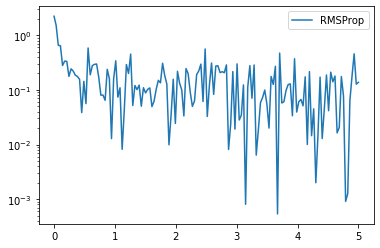

In [10]:
x_axis = np.linspace(0, 5, len(train_losses1), endpoint=True)
plt.semilogy(x_axis, train_losses1, label='RMSProp')
plt.legend(loc='best')